In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import matplotlib as mpl

def plot_all_psds(fig, ax, psds, deltaRs):
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.grid(True)

    ax.set_xlabel('k = 2*pi*fq')
    ax.set_ylabel('PSD')

    for deltaR, psd in zip(deltaRs, psds):

        # build numeric mapping for deltaR (fall back to index if non-numeric)
        try:
            drs = np.array([float(k) for k in deltaRs], dtype=float)
            dr_val = float(deltaR)
            # use log normalization because deltaR spans many decades
            norm = mpl.colors.LogNorm(vmin=drs.min(), vmax=drs.max())
        except Exception:
            keys = list(deltaRs)
            drs = np.arange(len(keys))
            dr_val = keys.index(deltaR)
            norm = mpl.colors.Normalize(vmin=0, vmax=len(keys) - 1)

        # choose a perceptually-uniform colormap
        cmap = plt.get_cmap('cool')
        color = cmap(norm(dr_val))

        # create a single ScalarMappable + colorbar once (store on fig)
        if not hasattr(fig, '_deltaR_sm'):
            sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])  # avoids warnings; colorbar uses the norm/cmap
            fig._deltaR_sm = sm
            cbar = fig.colorbar(sm, ax=ax)
            cbar.set_label('deltaR')

        # plot using the computed color
        fq = np.fft.fftfreq(len(psd))*2*np.pi
        # plot positive frequencies (psd values are already positive) as a line
        mask = fq > 0
        fq_plot = fq[mask]
        psd_plot = psd[mask]
        ax.plot(fq_plot, psd_plot, color=color, lw=1)


In [3]:
def save_psd_series_csv(path, deltaRs, psd_array, value_sep=','):
    """
    Save PSD series to CSV in long form with columns: deltaR, L, PSD.
    deltaRs: iterable of deltaR keys (order must match psd_array rows)
    psd_array: 2D numpy array with shape (len(deltaRs), series_length)
    """
    series_length = psd_array.shape[1]
    fq = np.fft.fftfreq(series_length)[:series_length // 2]
    psd_array = psd_array[:,:series_length // 2]

    deltaRs = list(deltaRs)
    psd_array = np.atleast_2d(psd_array)

    if psd_array.shape[0] != len(deltaRs):
        raise ValueError("Number of deltaR entries does not match number of PSD rows")

    series_length = psd_array.shape[1]

    # Build long-form columns
    delta_col = np.repeat(deltaRs, series_length)
    L_col = np.tile(np.arange(1, series_length + 1), len(deltaRs))  # L as 1..series_length
    fq_col = np.tile(fq, len(deltaRs))
    PSD_col = psd_array.ravel()

    print(len(fq))

    print(len(fq_col), len(delta_col), len(L_col), len(PSD_col))

    df_out = pd.DataFrame({'deltaR': delta_col, 'L': L_col, "fq" : fq_col, 'PSD': PSD_col})
    df_out.to_csv(path, index=False)

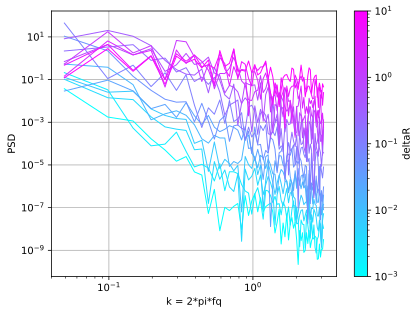

In [6]:
f = h5py.File("../results/2025-10-27-depinning-dR--3-1/partial/l-256-d-256/shapes.h5", "r")
fig, ax = plt.subplots()
psd_criticals = [ np.array(f[i]['1']['psd_critical'])[:128] for i in f.keys()]
plot_all_psds(fig, ax, psd_criticals, f.keys())

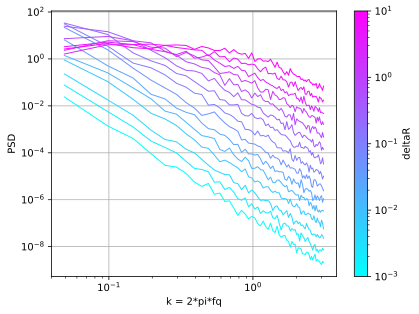

In [7]:
f = h5py.File("../results/2025-10-27-depinning-dR--3-1/partial/l-256-d-256/shapes.h5", "r")
fig, ax = plt.subplots()
seeds = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']

avg_over_seeds = list()
for seed in seeds:
    psd_crit_means = [np.array(f[i][seed]['psd-cm-mean'])[:128] for i in f.keys()]
    avg_over_seeds.append(psd_crit_means)

avg_over_seeds = np.array(avg_over_seeds)
avg_over_seeds = np.mean(avg_over_seeds, axis=0)
plot_all_psds(fig, ax, avg_over_seeds, f.keys())

64
960 960 960 960


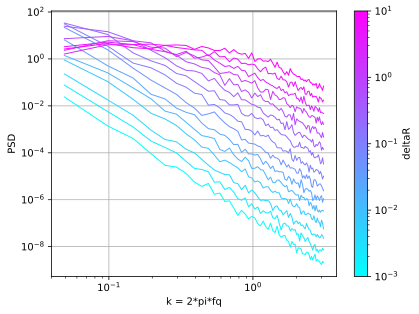

In [8]:
f = h5py.File("../results/2025-10-27-depinning-dR--3-1/partial/l-256-d-256/shapes.h5", "r")
avg_over_seeds = np.stack(
    [[np.array(f[deltaR][seed]['psd-cm-mean'])[:128] for deltaR in f.keys()] for seed in seeds],
    axis=0
)
avg_over_seeds = np.mean(avg_over_seeds, axis=0)
fig, ax = plt.subplots()

plot_all_psds(fig, ax, avg_over_seeds, f.keys())
# usage
save_psd_series_csv("psd_by_deltaR.csv", f.keys(), avg_over_seeds)

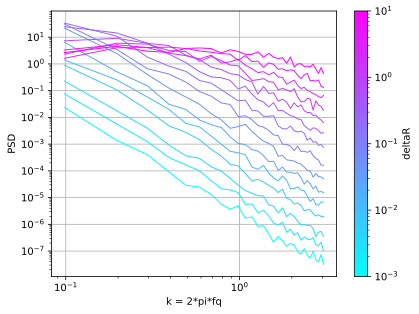

In [9]:
path = "./psd_by_deltaR.csv"

df = pd.read_csv(path)
# pivot to wide form: rows=deltaR (in appearance order), columns=L
pivoted = df.pivot(index='deltaR', columns='L', values='PSD')
pivoted = pivoted.sort_index(axis=1)  # ensure L columns are in numeric order

psds_from_csv = pivoted.values

fig, ax = plt.subplots()
plot_all_psds(fig, ax, psds_from_csv, pivoted.index)
plt.show()


In [4]:
# This cell saves all the stuff into csv files
from pathlib import Path

folder = "../results/2025-10-27-depinning-dR--3-1/partial"
# seeds = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']

shapes_paths = list(Path(folder).rglob('shapes.h5'))
if not shapes_paths:
    print("No shapes.h5 files found in", folder)

for p in shapes_paths:
    print("Processing:", p)
    with h5py.File(p, 'r') as f:
        insane_3d_array = list()
        for deltaR in f.keys():
            delta_seeds = list()
            print(f"Seed count atm: {len(f[deltaR].keys())}")
            for seed in f[deltaR].keys():
                a = np.array(f[deltaR][seed]['psd-cm-mean']).flatten()

                b = f[deltaR][seed]['psd-y1-mean']
                c = f[deltaR][seed]['psd-y2-mean']

                delta_seeds.append(a)
            insane_3d_array.append(delta_seeds)

        insane_3d_array = np.array(insane_3d_array)

        avg_over_seeds = np.mean(insane_3d_array, axis=1)
        
        csv_name = p.parent.name + ".csv"
        out_path = p.parent.joinpath(csv_name)
        deltaRs = list(f.keys())
        save_psd_series_csv(out_path, list(f.keys()), avg_over_seeds)
        other_path = Path("all_data_csv")
        other_path.mkdir(exist_ok=True, parents=True)
        save_psd_series_csv(other_path.joinpath(csv_name), list(f.keys()), avg_over_seeds)
        print("Wrote:", out_path)

Processing: ../results/2025-10-27-depinning-dR--3-1/partial/l-128-d-2/shapes.h5
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
64
960 960 960 960
64
960 960 960 960
Wrote: ../results/2025-10-27-depinning-dR--3-1/partial/l-128-d-2/l-128-d-2.csv
Processing: ../results/2025-10-27-depinning-dR--3-1/partial/l-64-d-64/shapes.h5
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
32
480 480 480 480
32
480 480 480 480
Wrote: ../results/2025-10-27-depinning-dR--3-1/partial/l-64-d-64/l-64-d-64.csv
Processing: ../result

In [5]:
# This cell saves all the stuff into csv files
from pathlib import Path

folder = "../results/2025-10-27-depinning-dR--3-1/partial"
# seeds = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']

shapes_paths = list(Path(folder).rglob('shapes.h5'))
if not shapes_paths:
    print("No shapes.h5 files found in", folder)

for p in shapes_paths:
    print("Processing:", p)
    with h5py.File(p, 'r') as f:
        insane_3d_array = list()
        for deltaR in f.keys():
            delta_seeds = list()
            print(f"Seed count atm: {len(f[deltaR].keys())}")
            for seed in f[deltaR].keys():
                a = np.array(f[deltaR][seed]['psd-y2-mean']).flatten()
                
                delta_seeds.append(a)
            insane_3d_array.append(delta_seeds)

        insane_3d_array = np.array(insane_3d_array)

        avg_over_seeds = np.mean(insane_3d_array, axis=1)
        
        csv_name = p.parent.name + "-y2.csv"
        out_path = p.parent.joinpath(csv_name)
        deltaRs = list(f.keys())
        save_psd_series_csv(out_path, list(f.keys()), avg_over_seeds)
        other_path = Path("all_data_csv")
        other_path.mkdir(exist_ok=True, parents=True)
        save_psd_series_csv(other_path.joinpath(csv_name), list(f.keys()), avg_over_seeds)
        print("Wrote:", out_path)

Processing: ../results/2025-10-27-depinning-dR--3-1/partial/l-128-d-2/shapes.h5
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
Seed count atm: 100
64
960 960 960 960
64
960 960 960 960
Wrote: ../results/2025-10-27-depinning-dR--3-1/partial/l-128-d-2/l-128-d-2-y2.csv
Processing: ../results/2025-10-27-depinning-dR--3-1/partial/l-64-d-64/shapes.h5
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
Seed count atm: 80
32
480 480 480 480
32
480 480 480 480
Wrote: ../results/2025-10-27-depinning-dR--3-1/partial/l-64-d-64/l-64-d-64-y2.csv
Processing: ../

In [10]:
# This cell saves all the stuff into csv files
from pathlib import Path

folder = "../results/2025-10-27-depinning-dR--3-1/perfect"
# seeds = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']

shapes_paths = list(Path(folder).rglob('shapes.h5'))
if not shapes_paths:
    print("No shapes.h5 files found in", folder)

for p in shapes_paths:
    print("Processing:", p)
    try:
        with h5py.File(p, 'r') as f:
            insane_3d_array = list()
            for deltaR in f.keys():
                delta_seeds = list()
                print(f"Seed count atm: {len(f[deltaR].keys())}")
                for seed in f[deltaR].keys():
                    a = np.array(f[deltaR][seed]['psd-mean']).flatten()
                    delta_seeds.append(a)
                insane_3d_array.append(delta_seeds)

            insane_3d_array = np.array(insane_3d_array)

            avg_over_seeds = np.mean(insane_3d_array, axis=1)
            
            csv_name = p.parent.name + ".csv"
            out_path = p.parent.joinpath(csv_name)
            deltaRs = list(f.keys())
            save_psd_series_csv(out_path, list(f.keys()), avg_over_seeds)
            other_path = Path("all_data_csv")
            other_path.mkdir(exist_ok=True, parents=True)
            save_psd_series_csv(other_path.joinpath(csv_name), list(f.keys()), avg_over_seeds)
            print("Wrote:", out_path)
    except:
        print(f"Failed to process: {p}")
        continue

Processing: ../results/2025-10-27-depinning-dR--3-1/perfect/l-64/shapes.h5
Seed count atm: 50
Seed count atm: 50
Seed count atm: 50
Seed count atm: 50
Seed count atm: 50
Seed count atm: 50
Seed count atm: 50
Seed count atm: 50
Seed count atm: 50
Seed count atm: 50
Seed count atm: 50
Seed count atm: 50
Seed count atm: 50
Seed count atm: 50
Seed count atm: 50
32
480 480 480 480
32
480 480 480 480
Wrote: ../results/2025-10-27-depinning-dR--3-1/perfect/l-64/l-64.csv
Processing: ../results/2025-10-27-depinning-dR--3-1/perfect/l-512/shapes.h5
Seed count atm: 3
Seed count atm: 3
Seed count atm: 3
Seed count atm: 3
Seed count atm: 3
Seed count atm: 3
Seed count atm: 3
Seed count atm: 3
Seed count atm: 3
Seed count atm: 3
Seed count atm: 3
Seed count atm: 3
Seed count atm: 3
Seed count atm: 3
Seed count atm: 3
256
3840 3840 3840 3840
256
3840 3840 3840 3840
Wrote: ../results/2025-10-27-depinning-dR--3-1/perfect/l-512/l-512.csv
Processing: ../results/2025-10-27-depinning-dR--3-1/perfect/l-32/sha

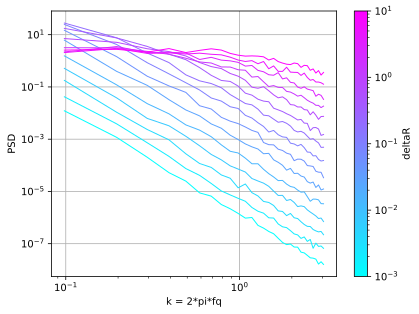

In [ ]:
def read_from_csv(path):
    df = pd.read_csv(path)
    # pivot to wide form: rows=deltaR (in appearance order), columns=L
    pivoted = df.pivot(index='deltaR', columns='L', values='PSD')
    pivoted = pivoted.sort_index(axis=1)  # ensure L columns are in numeric order

    psds_from_csv = pivoted.values

    bigL = psds_from_csv.shape[1]

    psds_from_csv = psds_from_csv[:, :(bigL // 2)]
    return psds_from_csv, pivoted.index

psds_from_csv, deltaRvals = read_from_csv(path = "./all_data_csv/l-256-d-64.csv")
fig, ax = plt.subplots()
plot_all_psds(fig, ax, psds_from_csv, deltaRvals)
plt.show()

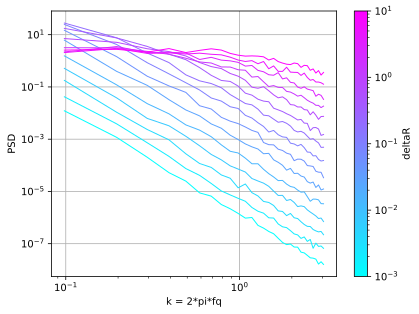

In [ ]:
psds_from_csv, deltaRvals = read_from_csv(path = "./all_data_csv/l-256-d-64.csv")
fig, ax = plt.subplots()
plot_all_psds(fig, ax, psds_from_csv, deltaRvals)
plt.show()

In [25]:
import pickle
path = "../results/2025-10-27-depinning-dR--3-1/perfect/l-32/shape_data/extra_info_dump-l-32-s-27.pickle"

with open(path, "rb") as fp:
    data = pickle.load(fp)

In [27]:
data[0].keys()

dict_keys(['tau_ext', 'converged', 'shapes'])